In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from keras.datasets import fashion_mnist

In [7]:
(x_train, y_train), (x_test, y_test)=fashion_mnist.load_data()

In [8]:
type(x_train)

numpy.ndarray

In [9]:
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

In [10]:
x_train.dtype,y_train.dtype

(dtype('uint8'), dtype('uint8'))

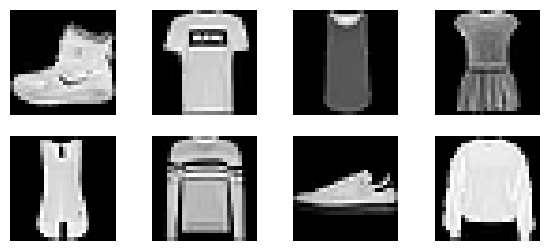

In [7]:
plt.figure(figsize=(7,3))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_train[i],cmap="grey")
    plt.axis("off")

plt.show()

In [8]:
img_shape=(28,28,1)
def build_generator():
    inp=layers.Input(100)
    
    x=layers.Dense(256)(inp)
    x=layers.LeakyReLU(alpha=0.2)(x)
    x=layers.BatchNormalization(momentum=0.8)(x)
    
    x=layers.Dense(512)(x)
    x=layers.LeakyReLU(alpha=0.2)(x)
    x=layers.BatchNormalization(momentum=0.8)(x)
    
    x=layers.Dense(1024)(x)
    x=layers.LeakyReLU(alpha=0.2)(x)
    x=layers.BatchNormalization(momentum=0.8)(x)

    x=layers.Dense(np.prod(img_shape),activation='tanh')(x)
    output=layers.Reshape(img_shape)(x)

    model = Model(inp,output)
    return model

generator=build_generator()
generator.summary()
    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048  

In [9]:
img_shape=(28,28,1)
def build_discriminator():
    inp=layers.Input(img_shape)
    
    x=layers.Flatten()(inp)
    x=layers.Dense(512)(x)    
    x=layers.LeakyReLU(alpha=0.2)(x)
    
    x=layers.Dense(256)(x)
    x=layers.LeakyReLU(alpha=0.2)(x)
    
    output=layers.Dense(1,activation='sigmoid')(x)
    

    model = Model(inp,output)
    return model

discriminator=build_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257 

In [10]:
x_train[0].min(),x_train[0].max()

(0, 255)

In [11]:
x_train_norm=(x_train.astype("float32")-127.5)/127.5

In [12]:
x_train_norm[0].min(),x_train_norm[0].max()

(-1.0, 1.0)

In [109]:

# | Label | Description |
# |:-----:|-------------|
# |   0   | T-shirt/top |
# |   1   | Trouser     |
# |   2   | Pullover    |
# |   3   | Dress       |
# |   4   | Coat        |
# |   5   | Sandal      |
# |   6   | Shirt       |
# |   7   | Sneaker     |
# |   8   | Bag         |
# |   9   | Ankle boot  |


In [4]:


def train(epochs,batch_size=128,save_interval=50):
    (x_train, y_train), (x_test, y_test)=fashion_mnist.load_data()
    x_train=(x_train.astype("float32")-127.5)/127.5
    x_train=np.expand_dims(x_train,axis=3)
    
    half_batch=batch_size//2
    for epoch in range(epochs):
        idx=np.random.randint(0,x_train.shape[0],half_batch)

        # real images
        imgs=x_train[idx]

        noise = np.random.normal(0,1,(half_batch,100))

        # Gen images
        gen_imgs=generator.predict(noise)

        # discriminator loss for real and gen images
        d_loss_real=discriminator.train_on_batch(imgs,np.ones((half_batch,1)))
        d_loss_gen=discriminator.train_on_batch(gen_imgs,np.zeros((half_batch,1)))

        # average real and gen loss
        d_loss=0.5* np.add(d_loss_real,d_loss_gen)

        # training genrator 
        noise = np.random.normal(0,1,(batch_size,100))

        valid_y=np.array([1]*batch_size)
        
        g_loss=combined.train_on_batch(noise,valid_y)

        if epoch%500==0:
            print(f"Epoch: {epoch} =|= D_loss: {d_loss[0]} =|= acc: {d_loss[1]} =|= G_loss: {g_loss}")

        if epoch%save_interval==0:
            pass


In [14]:
optimizer="Adam"
lr=0.0002
momentum = 0.5

discriminator.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])
generator.compile(loss="binary_crossentropy",optimizer=optimizer)

z=layers.Input(shape=(100,))
img=generator(z)

discriminator.trainable=False

valid=discriminator(img)

combined=Model(z,valid)
combined.compile(loss="binary_crossentropy",optimizer=optimizer)

In [2]:
generator=tf.keras.models.load_model("fashion_gen_G.h5")
discriminator=tf.keras.models.load_model("fashion_gen_D.h5")
combined=tf.keras.models.load_model("fashion_gen_C.h5")


In [17]:
train(epochs=5000,batch_size=32)

Epoch: 0 =|= D_loss: 0.7211111411452293 =|= acc: 0.8125 =|= G_loss: 3.552916950866347e-06
Epoch: 500 =|= D_loss: 0.3865221440792084 =|= acc: 0.84375 =|= G_loss: 1.0674584700609557e-05
Epoch: 1000 =|= D_loss: 0.5754869431257248 =|= acc: 0.75 =|= G_loss: 2.5314291178801795e-06
Epoch: 1500 =|= D_loss: 0.4928055927157402 =|= acc: 0.84375 =|= G_loss: 2.6047041501442436e-06
Epoch: 2000 =|= D_loss: 0.42795172333717346 =|= acc: 0.8125 =|= G_loss: 2.2196577447175514e-06
Epoch: 2500 =|= D_loss: 0.8046986311674118 =|= acc: 0.75 =|= G_loss: 7.283776994881919e-07
Epoch: 3000 =|= D_loss: 0.48076409474015236 =|= acc: 0.8125 =|= G_loss: 4.398447117637261e-07
Epoch: 3500 =|= D_loss: 0.37165461480617523 =|= acc: 0.875 =|= G_loss: 7.522465352849395e-07
Epoch: 4000 =|= D_loss: 0.5600297451019287 =|= acc: 0.78125 =|= G_loss: 3.542641024978366e-07
Epoch: 4500 =|= D_loss: 0.8861623108386993 =|= acc: 0.6875 =|= G_loss: 6.51501068205107e-07


In [21]:
generator.save("fashion_gen_G.h5")
discriminator.save("fashion_gen_D.h5")
combined.save("fashion_gen_C.h5")


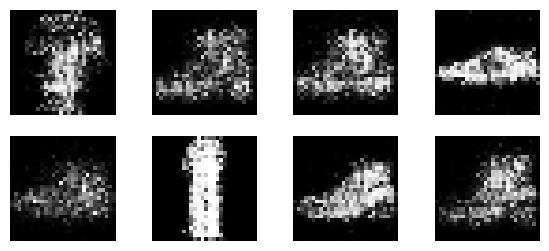

In [20]:

plt.figure(figsize=(7,3))
for i in range(8):
    tnoise=np.random.normal(0,1,(1,100))
    gen_img=generator.predict(tnoise)
    gen_img=(0.5* gen_img)+0.5
    plt.subplot(2,4,i+1)
    plt.imshow(gen_img[0],cmap="grey")
    plt.axis("off")

plt.show()
# plt.figure(figsize=(7,3))
# for i in range(8):
#     plt.subplot(2,4,i+1)
#     plt.imshow(x_train[i],cmap="grey")
#     plt.axis("off")

